Question 1

In [6]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import math
f =  cv2.imread('the_berry_farms_sunflower_field.jpeg',cv2.IMREAD_REDUCED_COLOR_4)#gray scale conversion
f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR format, convert to RGB

# Convert the color image to grayscale
img = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)

from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

In [7]:
def LoG(sigma):
    '''Laplacian of Gaussian Function'''
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    log = 1/(2*np.pi*sigma**2)*(x**2/(sigma**2) + y**2/(sigma**2) - 2)*np.exp(-(x**2 + y**2)/(2*sigma**2))
    return log

In [8]:
def LoG_convolve(img):
    '''Laplacian of Gaussian Convolution'''
    scale_space = [] #scale space
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y #computing value of sigma
        print(sigma_1)
        filter_log = LoG(sigma_1) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding the image
        image = np.square(image) # squaring the response
        scale_space.append(image)
    scale_space_np = np.array([i for i in scale_space]) # converting the scale space to an array
    return scale_space_np
scale_space_np = LoG_convolve(img)

1.0
1.414
1.9993959999999997
2.8271459439999997
3.997584364815999
5.652584291849823
7.992754188675648
11.301754422787367
15.980680753821336


In [9]:
def detect_blob(log_image_np):
    '''detecting blobs by finding the maximum in the scale space'''
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] #9*3*3 slice
            result = np.amax(slice_img) #finding maximum
            if result >= 0.03: #threshold
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) #finding co-rdinates
    return co_ordinates
co_ordinates = list(set(detect_blob(scale_space_np)))#List of coordinates where the LoG is maximum in the scale space

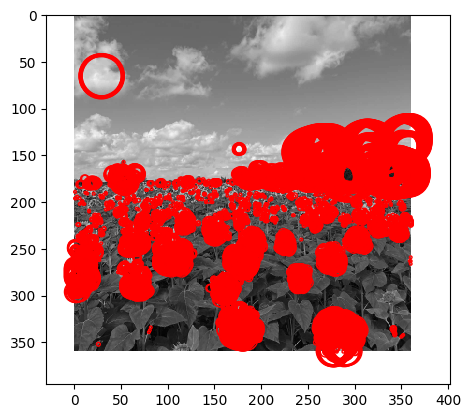

In [10]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0
ax.imshow(img, interpolation='nearest',cmap="gray")
#Circle each place where a blob might be present
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

Preventing Overlaps between blobs 

In [11]:
#determining whether two blobs overlaps by finding the area between them
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    #finding the distance between their two centers
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)
        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)
        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1
        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))

In [12]:
#function to obtain only the non overlapping blobs from an array of overlapping blobs
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
    return np.array([b for b in blobs_array if b[-1] > 0])



In [13]:
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

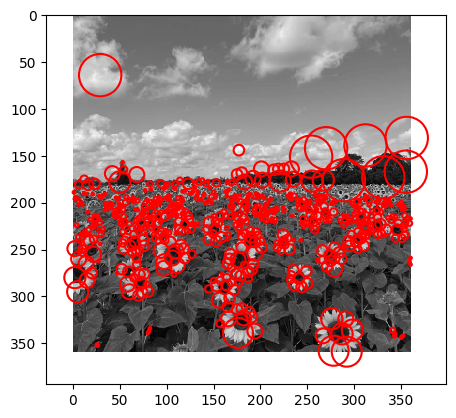

(29.0, 64.0, 15.980680753821336, 414)


In [16]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0
ax.imshow(img, interpolation='nearest',cmap="gray")
r_max = 0
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    if r*1.414>r_max:
        max_param = (x,y, r*1,414)
        r_max = r*1.414
    ax.add_patch(c)
ax.plot()  
plt.show()
print(max_param)